# Wilkommen zur interaktiven Vorlesung

Bitte lassen Sie das gesamte Notebook von vorne laufen. Dies ist wichtig, so dass alle Python-Module und die Daten in der richtigen Reihenfolge geladen werden.

In [1]:
# importiere alle notwendigen packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from functions import helper_fcts
import ipywidgets as widgets

# Budyko and die klimatische Wasserbilanz 

## Mikhail Ivanovich Budyko (20.01.1920 – 10.12.2001)

In den Jahren 1955-1974 studierte Mikhail Budyko ([Bildquelle mit Biographie](https://public.wmo.int/en/about-us/awards/international-meteorological-organization-imo-prize/mikhail-ivanovich-budyko)) im Rahmen seiner Forschungen die Komponenten der Land- und Meeresenergiebilanz, was in Russland und darüber hinaus weithin anerkannt wurde und den Grundstein für einen neuen Bereich der Meteorologie legte - die physikalische Klimatologie (Theorie des Klimas). 

<img src="https://ane4bf-datap1.s3-eu-west-1.amazonaws.com/wmocms/s3fs-public/styles/featured_media_detail/public/advanced_page/featured_media/Budyko.png?sVsiFNvfuHQf792994VKiDrakKn_AGLD&itok=bpEQF8dL" alt="drawing" width="300"/>


## Die langfristige Wasserbilanz eines Einzugsgebiets
Budyko nimmt an, dass die Wasserbilanz großer Einzugsgebiete ($\gg$1000 km²) nur vom Klima kontrolliert wird. 
Die langfristige Wasserbilanz für ein Einzugsgebiet ist dann:

\begin{equation}
\tag{1}
P = AET + Q \label{water_balance}
\end{equation}

wobei $P$ den Niederschlag beschreibt, $AET$ die tatsächliche Verdunstung und $Q$ den Abfluss (alle in mm/y).

Und die Energiebilanz ist:

\begin{equation}
\tag{2}
R_n = L + H + G \label{energy_balance}
\end{equation}

wobei $R_n$ die Nettostrahlung beschreibt, $L$ die latente Wärme, $H$ die sensible Wärme und $G$ den Bodenwärmefluss (alle in W/m²).

## Der Zusammenhang zwischen Wasser- und Energiebilanz

Die latente Wärme kann auch über die tatsächliche Verdunstung ausgedrückt werden:

\begin{equation}
\tag{3}
L = \lambda_w AET \label{latent_heat}
\end{equation}

wobei $\lambda_w$ die Verdunstungsenthalpie ist, also die Menge an Energie, die es braucht um eine bestimmte Menge an Wasser zu verdampfen (diese ist leicht abhängig von der Temperatur $T$). 

Die sogenannte potentielle Verdunstung $PET$ kann über die Nettostrahlung genähert werden:

\begin{equation}
\tag{4}
PET = Rn/\lambda_w \label{potential_evaporation}
\end{equation}

Der Bodenwärestrom wird häufig vernachlässigt, so dass sich folgende Gleichung ergibt:

\begin{equation}
\tag{5}
R_n = \lambda_w AET + H \label{energy_and_water_balance}
\end{equation}

Gleichung (5) verbindet nun also die Wasserbilanz mit der Energiebilanz und ist somit eine wichtige Grundlage der Hydroklimatologie.

## Die klimatische Wasserbilanz 

Die klimatische Wasserbilanz ist definiert als $P - PET$.
Sie ist eng verwandt mit dem sogenannten Trockenheitsindex $\phi$ (manchmal auch Aridität genannt):

\begin{equation}
\tag{6}
\phi = \frac{PET}{P} \label{aridity_index}
\end{equation}

Gebiete, in denen $P$ größer als $PET$ ist, werden als *energie-limitiert* bezeichnet. 
Gebiete, in denen $P$ kleiner als $PET$ ist, werden als *wasser-limitiert* bezeichnet.

In wasser-limitierten ist die klimatische Wasserbilanz negativ (bzw. $\phi > 1$).
In solchen Gebieten kann nicht alle Energie genutzt werden um Wasser zu verdunsten, da nicht genügend Wasser vorhanden ist. 
Die Energie, die nicht genutzt wird um Wasser zu verdunsten, wird in fühlbare Wärme $H$ umgewandelt.
In energie-limitierten Gebieten hingegen kann (fast) alle Energie genutzt werden ($PET \approx AET$), und folglich sollte $P - PET$ ungefähr dem Abfluss $Q$ entsprechen.

Plottet man nun den Abfluss gegen die klimatische Wasserbilanz, so sieht man einen starken Zusammenhang. 
Die Stärke des Zusammenhangs kann man z.B. mit der sogenannten Spearman Rangkorrelation $\rho_s$ beschreiben.
Gibt es Unterschiede zwischen wasser- und energie-limitierten Gebieten? 


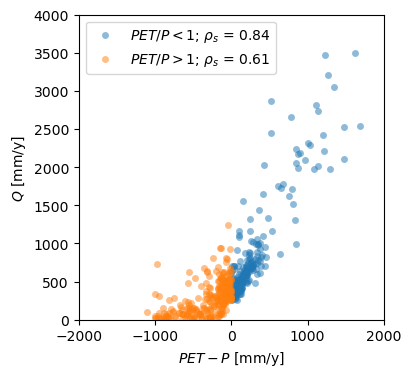

In [2]:
# todo: add more comments

# load data
df = pd.read_csv("results/caravan_processed.csv")

df["aridity_class"] = 0
df.loc[df["aridity_netrad"] > 1, "aridity_class"] = 1
df["climatic_water_balance"] = df["total_precipitation_sum"] - df["netrad"]

def plot_climatic_water_balance(*args):
    
    x_name = "climatic_water_balance"
    y_name = "streamflow"
    
    fig = plt.figure(figsize=(4, 4), constrained_layout=True)
    axes = plt.axes()
    
    r_sp_energy_limited, _ = stats.spearmanr(df.loc[df["aridity_class"] == 0, x_name], 
                                             df.loc[df["aridity_class"] == 0, y_name],
                                             nan_policy='omit')
    
    r_sp_water_limited, _ = stats.spearmanr(df.loc[df["aridity_class"] == 1, x_name],
                                            df.loc[df["aridity_class"] == 1, y_name],
                                            nan_policy='omit')
    
    im = axes.scatter(df.loc[df["aridity_class"] == 0, x_name]*365, df.loc[df["aridity_class"] == 0, y_name]*365,
                      s=25, c="tab:blue", alpha=0.5, lw=0,
                      label=r"$PET/P < 1$; $\rho_s$ = " + str(np.round(r_sp_energy_limited,2)))    
    
    im = axes.scatter(df.loc[df["aridity_class"] == 1, x_name]*365, df.loc[df["aridity_class"] == 1, y_name]*365,
                      s=25, c="tab:orange", alpha=0.5, lw=0,
                      label=r"$PET/P > 1$; $\rho_s$ = " + str(np.round(r_sp_water_limited,2)))
    
    axes.set_xlabel("$PET - P$ [mm/y]")
    axes.set_ylabel("$Q$ [mm/y]")
    axes.set_xlim([-2000, 2000])
    axes.set_ylim([0, 4000])
    axes.legend(loc='best')
    axes.set_aspect('equal', adjustable='box')
    #axes.grid()

plot_climatic_water_balance()
    
%matplotlib inline

Der Zusammenhang zwischen der klimatischen Wasserbilanz und dem Abfluss ist sehr stark, inbesondere in energie-limitierten Gebieten.
Hier sollte $P - PET$ ungefähr $Q$ entsprechen, da genügend Wasser verfügbar ist und somit (fast) alle Energie für Verdunstung (d.h. $AET$) genutzt werden kann.
Der Zusammenhang ist allerdings nie perfekt. Zum einen sind Umweltdaten immer mit Unsicherheit behaftet. 
Zum anderen gibt es noch weitere Faktoren über die klimatische Wasserbilanz hinaus, die die Abflussbildung beeinflussen. Diese werden wir später erarbeiten.

## Budyko Kurve

Die Unterteilung in wasser- und energielimitiert bildet die Grundlage von Budykos Kurve. 

In energie-limitierten Gebieten (z.B. feuchte Gebiete wie Schottland oder Schweden) nähert sich die Verdunstung der potentiellen Verdunstung an.

\begin{equation}
%\tag{}
AET \rightarrow PET \label{}
\end{equation}

In wasser-limitierten Gebieten (z.B. trockene Gebiete wie Südspanien oder die Sahara) nähert sich die Verdunstung dem Niederschlag an.

\begin{equation}
%\tag{}
AET \rightarrow P \label{}
\end{equation}

Wir definieren nun neben dem Trockenheitsindex noch den sogenannten Verdunstungsindex:

\begin{equation}
\tag{7}
\psi = AET / P \label{evaporative_faction}
\end{equation}

Für zunehmend wasser-limitierte ("aride") Gebiete, nähert sich der Verdunstungsindex 1 an, da der ganze Niederschlag verdunstet.
Für zunehmend energie-limitierte ("humide") Gebiete, nähert sich der Verdunstungsindex dem Trockenheitsindex an, da alles Energie für die Verdunstung genutzt wird.

<img src="Budyko_curve.png" alt="drawing" width="400"/>

Im folgenden schauen wir uns das ganze mit echten Daten an.

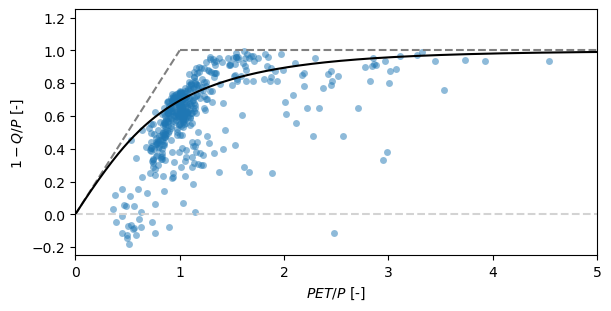

In [3]:
def plot_Budyko(plot_curve=False,*args):
    
    #todo: add comments
    fig = plt.figure(figsize=(6, 3), constrained_layout=True)
    axes = plt.axes()
    x_name = "aridity_netrad"
    y_name = "runoff_ratio"
    im = axes.scatter(df[x_name], 1-df[y_name], s=25, alpha=0.5, lw=0) 
    axes.set_xlabel("$PET/P$ [-]")
    axes.set_ylabel("$1 - Q/P$ [-]")
    axes.set_xlim([0, 5])
    axes.set_ylim([-0.25, 1.25])
    helper_fcts.plot_Budyko_limits(df[x_name], df[y_name], axes)
    #axes.set_xscale('log')
    
    if plot_curve == True:
        # plot Budyko curve
        helper_fcts.plot_Budyko_curve(np.linspace(0.01,10,1000), axes)
    
plot_Budyko(plot_curve=True)

%matplotlib inline

## Budyko Kurve mit Daten
Der Plot zeigt, dass die meisten Datenpunkte den von Budyko postulierten Grenzen folgen. Die Kurve passt zwar nicht perfekt, gibt aber dennoch den generellen Trend gut wieder. 

Es gibt allerdings viele Punkte, die deutlich unter der Kurve liegen. Um diese Abweichungen zu verdeutlichen kann man die Daten mit der Kurve vergleichen und entsprechend der jeweiligen Abweichung einfärben.

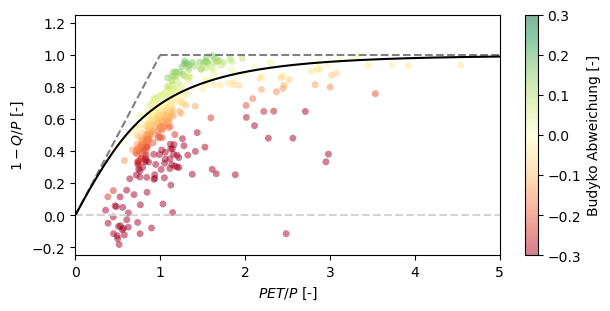

In [4]:
def plot_Budyko_anomaly(*args):
    
    #todo: add dict for z name and unit
    fig = plt.figure(figsize=(6, 3), constrained_layout=True)
    axes = plt.axes()
    x_name = "aridity_netrad"
    y_name = "runoff_ratio"
    z_name = "Budyko_anomaly"
    im = axes.scatter(df[x_name], 1-df[y_name], s=25, c=df[z_name], alpha=0.5, lw=0, cmap='RdYlGn') 
    axes.set_xlabel("$PET/P$ [-]")
    axes.set_ylabel("$1 - Q/P$ [-]")
    axes.set_xlim([0, 5])
    axes.set_ylim([-0.25, 1.25])
    helper_fcts.plot_Budyko_limits(df[x_name], df[y_name], axes)
    helper_fcts.plot_Budyko_curve(np.linspace(0.01,10,1000), axes)   
    #axes.set_xscale('log')
    cbar = fig.colorbar(im, ax=axes)
    cbar.set_label("Budyko Abweichung [-]")   
    cbar.mappable.set_clim(vmin=-0.3,vmax=0.3)

# calculate anomalies    
df["evaporative_fraction"] = helper_fcts.Budyko_curve(df["aridity_netrad"])
df["Budyko_anomaly"] = (1 - df["runoff_ratio"]) - df["evaporative_fraction"]

plot_Budyko_anomaly()

%matplotlib inline

## Abweichungen von der Budyko Kurve
Abgesehen von Unsicherheiten in den Daten, welche Gründe könnte es für eine Abweichung von der Linie geben?

Überlegen Sie sich mindestens drei Gründe (Hypothesen) für die Abweichungen von der Budykokurve. 

z.B. mit ChatGPT (https://openai.com/blog/chatgpt), Google Scholar, Wikipedia, Bücher

Im nächsten Teil werden sie diese Hypotheses zur Erklärung der Abweichungen mit Daten überprüfen.

## Gründe für Abweichungen von der Budyko Kurve

Um herauszufinden, welche der oben genannten Gründe die Abweichungen verursachen könnten, können wir verschiedene Einzugsgebietseigenschaften nutzen.

# link to correlation plots



In [5]:
def plot_Budyko_attributes(x):
    
    # todo: add dict for z name and unit and add more attributes
    dict_names = {'seasonality': 'Saisonalität [-]', 
                  'frac_snow': 'Schnee-Anteil [-]', 
                  'slp_dg_sav': 'Topographische Steigung [-]', 
                  'cly_pc_sav': 'Ton-Anteil [-]', 
                  'for_pc_sse': 'Wald-Anteil [-]', 
                  'hft_ix_s09': 'Menschlicher Fußbadruck [-]',
                  'area': 'Einzugsgebietsfläche [km$^2$]'}
    
    fig, axes = plt.subplots(figsize=(10, 3), constrained_layout=True, nrows=1, ncols=2, gridspec_kw={'width_ratios': [2, 1]})
    #axes = fig.subfigures(1, 2, wspace=0.07)
    
    #axes = plt.axes()
    x_name = "aridity_netrad"
    y_name = "runoff_ratio"
    z_name = x #"frac_snow"
    z_unit = " [-]"
    im = axes[0].scatter(df[x_name], 1-df[y_name], s=25, c=df[z_name], alpha=0.5, lw=0) #, s=df["area"]/100
    axes[0].set_xlabel("$PET/P$ [-]")
    axes[0].set_ylabel("$1 - Q/P$ [-]")
    axes[0].set_xlim([0, 5])
    axes[0].set_ylim([-0.25, 1.25])
    helper_fcts.plot_Budyko_limits(df[x_name], df[y_name], axes[0])
    helper_fcts.plot_Budyko_curve(np.linspace(0.01,10,1000), axes[0])
    #axes.set_xscale('log')
    cbar = fig.colorbar(im, ax=axes[0])
    cbar.set_label(dict_names[x])    
    
    #fig = plt.figure(figsize=(4, 3), constrained_layout=True)
    #axes = plt.axes()
    x_name = x
    y_name = "Budyko_anomaly"
    r_sp, _ = stats.spearmanr(df[x_name], df[y_name], nan_policy='omit')
    im = axes[1].scatter(df[x_name], df[y_name], s=25, c=df[y_name], alpha=0.5, lw=0, cmap='RdYlGn', 
                      label=r"$\rho_s$ = " + str(np.round(r_sp,2)))   
    axes[1].set_xlabel(dict_names[x])    
    axes[1].set_ylabel("Budyko Abweichung [-]")
    #axes[1].set_ylim([-1, 1])
    axes[1].legend(loc='best')
    cbar = fig.colorbar(im, ax=axes[1])
    cbar.set_label("Budyko Abweichung [-]")   
    cbar.mappable.set_clim(vmin=-0.3,vmax=0.3)
    #axes.grid()
    
    # give some info about how the attributes are defined
    dict_explanations = {'seasonality': 'Saisonalität des Niederschlags; 0 bedeutet keine Saisonalität, 2 bedeutet eine sehr starke Saisonalität.', 
                         'frac_snow': 'Anteil des Niederschlags der als Schnee fällt.', 
                         'slp_dg_sav': 'Durchschnittliche topographische Steigung des Einzugsgebiets.',
                         'cly_pc_sav': 'Ton-Anteil des Bodens.', 
                         'for_pc_sse': 'Wald-Anteil im Einzugsgebiet.', 
                         'hft_ix_s09': 'Menschlicher Fußbadruck im Einzugsgebiet.',
                         'area': 'Fläche des Einzugsgebiet.'}
    print(dict_explanations[x])

# todo: rename attributes    
widgets.interact(plot_Budyko_attributes, x=['seasonality', 'frac_snow', 'slp_dg_sav', 'cly_pc_sav', 'for_pc_sse', 'hft_ix_s09', 'area'])

# todo: add more attributes

# todo: explain correlation and maybe use pearson

%matplotlib inline

interactive(children=(Dropdown(description='x', options=('seasonality', 'frac_snow', 'slp_dg_sav', 'cly_pc_sav…

## Annahmen der Budyko Kurve

Nur für langjährige Mittelwerte kann die Änderung des Speichers als null angenommen werden.

Außerdem wurde die Theorie von Budyko ursprünglich für große Einzugsgebiete entwickelt.

Testen sie nun diese Annahmen, in dem sie sich die Größe der Einzugsgebiete anschauen sowie langjährige Mittelwerte auch mit jährlichen und 10-jährigen Mittelwerten vergleichen.

In [8]:
def plot_Budyko_assumptions(x):
    
    # calculate evaporative fraction and Budyko anomaly for subperiod
    df["evaporative_fraction"+'_'+x] = helper_fcts.Budyko_curve(df["aridity_netrad"])
    df["Budyko_anomaly"+'_'+x] = (1 - df["runoff_ratio"+'_'+x]) - df["evaporative_fraction"+'_'+x]
    
    fig, axes = plt.subplots(figsize=(10, 3), constrained_layout=True, nrows=1, ncols=2, gridspec_kw={'width_ratios': [2, 1]})
    #axes = fig.subfigures(1, 2, wspace=0.07)
    
    #axes = plt.axes()
    x_name = "aridity_netrad"
    y_name = "runoff_ratio"
    im = axes[0].scatter(df[x_name], 1-df[y_name], s=25, c="lightgrey", alpha=1, lw=0) 
    im = axes[0].scatter(df[x_name+'_'+x], 1-df[y_name+'_'+x], s=25, c="tab:red", alpha=0.5, lw=0) 
    axes[0].set_xlabel("$PET/P$ [-]")
    axes[0].set_ylabel("$1 - Q/P$ [-]")
    axes[0].set_xlim([0, 5])
    axes[0].set_ylim([-0.25, 1.25])
    helper_fcts.plot_Budyko_limits(df[x_name], df[y_name], axes[0])
    #axes.set_xscale('log')
    helper_fcts.plot_Budyko_curve(np.linspace(0.01,10,1000), axes[0])
    
    #fig = plt.figure(figsize=(4, 3), constrained_layout=True)
    #axes = plt.axes()
    y_name = "Budyko_anomaly"
    df[y_name+'_'+x] = (1 - df["runoff_ratio"+'_'+x]) - df["evaporative_fraction"+'_'+x]
    im = axes[1].scatter(df[y_name], df[y_name+'_'+x], s=25, c="black", alpha=1, lw=0)
    im = axes[1].scatter(df[y_name], df[y_name+'_'+x], s=25, c="black", alpha=1, lw=0)
    axes[1].plot(np.linspace(-5,5,10), np.linspace(-5,5,10),'--',c='gray')
    axes[1].set_xlabel("Budyko Abweichung [-] gesamt" )    
    axes[1].set_ylabel("Budyko Abweichung [-] " + x)
    #axes[1].set_ylim([-1, 1])
    #axes.grid()
    axes[1].set_aspect('equal', adjustable='box')
    axes[1].set_xlim([-1, 1])
    axes[1].set_ylim([-1, 1])
    
widgets.interact(plot_Budyko_assumptions, x=['1981','1982','1983','1984','1985','1981-1990','1991-2000','2001-2010'])

%matplotlib inline
    
#todo: add Budyko curve for small and large areas and for shorter time periods

interactive(children=(Dropdown(description='x', options=('1981', '1982', '1983', '1984', '1985', '1981-1990', …

# todo 
check size of catchments

In [45]:
def plot_Budyko_assumptions(x):
        
    fig, axes = plt.subplots(figsize=(10, 3), constrained_layout=True, nrows=1, ncols=2, gridspec_kw={'width_ratios': [2, 1]})
    #axes = fig.subfigures(1, 2, wspace=0.07)
    
    if x == 'x < 200':
        df_tmp = df.loc[(df["area"]<200)]
        
    elif x == '200 < x < 500':
        df_tmp = df.loc[np.logical_and(df["area"]>200,df["area"]<500)]
        
    elif x == '500 < x < 1000':
        df_tmp = df.loc[np.logical_and(df["area"]>500,df["area"]<1000)]
        
    elif x == 'x > 1000':
        df_tmp = df.loc[(df["area"]>1000)]
        
    else:
        print("Category not available.")
        
    #axes = plt.axes()
    x_name = "aridity_netrad"
    y_name = "runoff_ratio"
    im = axes[0].scatter(df[x_name], 1-df[y_name], s=25, c="lightgrey", alpha=1, lw=0) 
    im = axes[0].scatter(df_tmp[x_name], 1-df_tmp[y_name], s=25, c="tab:red", alpha=0.5, lw=0) 
    axes[0].set_xlabel("$PET/P$ [-]")
    axes[0].set_ylabel("$1 - Q/P$ [-]")
    axes[0].set_xlim([0, 5])
    axes[0].set_ylim([-0.25, 1.25])
    helper_fcts.plot_Budyko_limits(df_tmp[x_name], df_tmp[y_name], axes[0])
    #axes.set_xscale('log')
    helper_fcts.plot_Budyko_curve(np.linspace(0.01,10,1000), axes[0])
    
    #fig = plt.figure(figsize=(4, 3), constrained_layout=True)
    #axes = plt.axes()
    im = axes[1].hist(df["area"], np.linspace(0,2000,40), facecolor="grey")
    axes[1].set_xlabel("Area [km$^2$]")
    axes[1].set_ylabel("Count")
    axes[1].set_xlim([0, 2000])
    
widgets.interact(plot_Budyko_assumptions, x=['x < 200','200 < x < 500','500 < x < 1000','x > 1000'])

%matplotlib inline
    
#todo: add Budyko curve for small and large areas and for shorter time periods

interactive(children=(Dropdown(description='x', options=('x < 200', '200 < x < 500', '500 < x < 1000', 'x > 10…

# todo
plot one catchment for multiple years
10 y averages